In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch

Dataset size: 36718
row number 0: {'text': ''}
row number 1: {'text': ' = Valkyria Chronicles III = \n'}
row number 2: {'text': ''}
row number 3: {'text': ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n'}


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


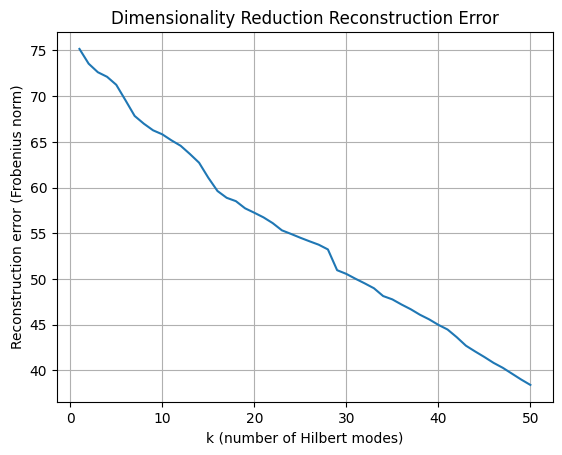

In [5]:
# ======================================================================================================================
# Experiment (2)
# Dimensionality Reduction of Language
# ======================================================================================================================

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load dataset and pretrained model/tokenizer
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")      # Load text data from the Wikitext-2 dataset.
print(f"Dataset size: {len(dataset)}")
print("row number 0:", dataset[0])
print("row number 1:", dataset[1])
print("row number 2:", dataset[2])
print("row number 3:", dataset[3])

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()                                   # Load pretrained BERT tokenizer and model (bert-base-uncased), set to evaluation mode.

texts = dataset['text'][:100]                  # Take first 100 texts
embeddings = []
with torch.no_grad():
    for text in texts:
        if not text.strip():
            continue
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)

D = np.stack(embeddings)

D_norm = D - D.mean(axis=0, keepdims=True)

def hankel_topk(T, k):
    """
    Returns top-k spectral filters
    """
    Z = np.zeros((T, T), dtype=np.float64)                # Construct Z (Hankel) matrix
    for i in range(T):
        for j in range(T):
            s = (i + 1) + (j + 1)  # 1-based indexing
            Z[i, j] = 2 / (s**3 - s)
    w, U = LA.eigh(Z, subset_by_index=(T - k, T - 1), check_finite=False)   # top-k evals and evecs
    Q, _ = np.linalg.qr(U)                              # orthonormal basis Q spanning the same subspace as U (Txk)
    return Q

#def project_with_phi(Phi, D):
  #  Q, _ = np.linalg.qr(Phi)
  #  Dprime = Q.T @ D
  #  Dhat = Q @ Dprime
  #  return Dhat

ks = np.arange(1, 51)
errs = []
for k_i in ks:
    T_data = D_norm.shape[0]
    Phi = hankel_topk(T_data, k_i)  # Generate basis with matching time dimension
    M, _, _, _ = np.linalg.lstsq(Phi, D_norm, rcond=None)  # k_i x d # Learn an M that is kxd that projects via linear regression fit
    errs.append(np.linalg.norm(D_norm - Phi @ M, ord='fro'))

plt.plot(ks, errs)
plt.xlabel('k (number of Hilbert modes)')
plt.ylabel('Reconstruction error (Frobenius norm)')
plt.title('Dimensionality Reduction Reconstruction Error')
plt.grid(True)
plt.show()